In [6]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


# Loading Data:

In [7]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,120)

In [8]:
def load_data():
    
    datasets = ['/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TRAIN','/kaggle/input/blood-cells/dataset2-master/dataset2-master/images/TEST']
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # resize the image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels

In [9]:
images, labels = load_data()

100%|██████████| 623/623 [00:02<00:00, 230.74it/s]


In [10]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [11]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 9955
Number of validation examples: 1245
Number of testing examples: 1244
Training images are of shape: (9955, 120, 120, 3)
Training labels are of shape: (9955,)
Validation images are of shape: (1245, 120, 120, 3)
Validation labels are of shape: (1245,)
Test images are of shape: (1244, 120, 120, 3)
Test labels are of shape: (1244,)


In [12]:
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

**Building Custom Model**

In [13]:
model1 = Sequential()

# First Conv Layer
model1.add(Conv2D(16 , (3,3) , activation = 'relu' , input_shape = (120,120,3)))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv Layer
model1.add(Conv2D(32, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# Third Conv Layer
model1.add(Conv2D(64, (3,3), activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.25))

# FC layer
model1.add(Flatten())
model1.add(Dense(units = 128 , activation = 'relu'))
model1.add(Dropout(0.25))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 10, 
    validation_data=(val_images, val_labels))

2022-01-12 16:49:44.607004: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 16:49:44.738840: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 16:49:44.739627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-12 16:49:44.740780: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 118, 118, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 59, 59, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 57, 57, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 26, 26, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0

2022-01-12 16:49:46.877209: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1720224000 exceeds 10% of free system memory.
2022-01-12 16:49:48.594425: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1720224000 exceeds 10% of free system memory.
2022-01-12 16:49:49.846160: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2022-01-12 16:49:51.470267: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


312/312 [==============================] - 10s 10ms/step - loss: 1.3949 - accuracy: 0.2430 - val_loss: 1.3866 - val_accuracy: 0.2369
Epoch 2/10
312/312 [==============================] - 3s 9ms/step - loss: 1.3865 - accuracy: 0.2480 - val_loss: 1.3868 - val_accuracy: 0.2466
Epoch 3/10
312/312 [==============================] - 3s 8ms/step - loss: 1.3868 - accuracy: 0.2496 - val_loss: 1.3865 - val_accuracy: 0.2361
Epoch 4/10
312/312 [==============================] - 3s 8ms/step - loss: 1.3867 - accuracy: 0.2518 - val_loss: 1.3875 - val_accuracy: 0.2683
Epoch 5/10
312/312 [==============================] - 3s 8ms/step - loss: 1.3861 - accuracy: 0.2578 - val_loss: 1.3879 - val_accuracy: 0.2402
Epoch 6/10
312/312 [==============================] - 3s 8ms/step - loss: 1.3782 - accuracy: 0.2862 - val_loss: 1.3558 - val_accuracy: 0.3462
Epoch 7/10
312/312 [==============================] - 3s 9ms/step - loss: 1.0569 - accuracy: 0.5133 - val_loss: 0.7842 - val_accuracy: 0.6827
Epoch 8/10
312/

# Evaluating performance

In [14]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(10)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

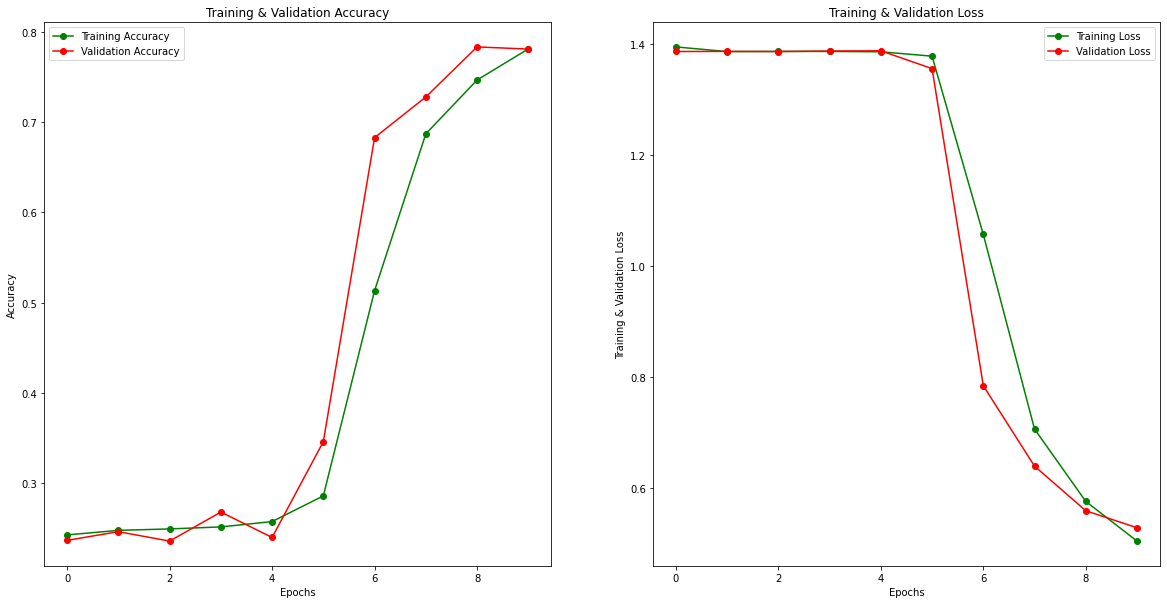

In [15]:
plot_accuracy_loss_chart(history1)

In [16]:

results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model1.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

39/39 [==============================] - 0s 7ms/step - loss: 0.4512 - accuracy: 0.8055
Loss of the model  is - test  0.4512442350387573
Accuracy of the model is - test 80.54662346839905 %
39/39 [==============================] - 0s 5ms/step - loss: 0.5281 - accuracy: 0.7807
Loss of the model  is - val  0.528099775314331
Accuracy of the model is - val 78.07229161262512 %


2022-01-12 16:50:36.029453: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1720224000 exceeds 10% of free system memory.
2022-01-12 16:50:37.738974: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1720224000 exceeds 10% of free system memory.


312/312 [==============================] - 2s 5ms/step - loss: 0.4142 - accuracy: 0.8391
Loss of the model  is - train  0.41421571373939514
Accuracy of the model is - train 83.90758633613586 %


In [17]:
from sklearn.metrics import classification_report

predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([3, 2, 3, 2, 2, 3, 1, 3, 0, 0, 3, 1, 1, 0, 0])

In [18]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.63      0.73      0.68       299
LYMPHOCYTE (Class 1)       0.95      0.95      0.95       317
  MONOCYTE (Class 2)       0.97      0.85      0.90       308
NEUTROPHIL (Class 3)       0.72      0.69      0.70       320

            accuracy                           0.81      1244
           macro avg       0.82      0.80      0.81      1244
        weighted avg       0.82      0.81      0.81      1244



In [19]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,219,2,3,75
1,11,300,5,1
2,21,14,261,12
3,98,0,0,222


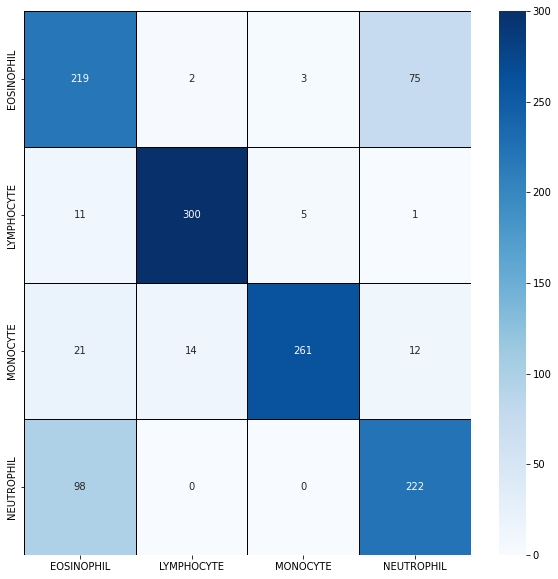

In [20]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)